<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Aprendizagem de máquina para ajustar os dados faltantes do sensor do peso sobre a broca</h1>
</div>

Na perfuração dos poços de petróleo são utilizados equipamentos compostos por uma sequência de tubos e uma broca em sua extremidade. Nesse conjunto é aplicado uma rotação e o peso sobre toda a estrutura, que é chamada de coluna de perfuração,  fragmenta a rocha no fundo dos poços. Esses conceitos são retratados na animação <a href="https://www.linkedin.com/posts/alison-silva-217212135_activity-6858874651595153408-szUA/?utm_source=linkedin_share&utm_medium=member_desktop_web" target="_blank" rel="noopener noreferrer">Sonda de Perfuração</a>, elaborada pela Pertroanimes com  maiores detalhes.

Sensores estão acoplados aos diversos equipamentos de perfuração para o monitoramento, porém, tais dispositivos estão suscetíveis a falhas, o que acarreta na falta de dados.

Um modelo de aprendizagem de máquina será utilizado para corrigir os dados faltantes gerados devido a deficiência do sensor do peso sobre a broca, também conhecido como Weight on BIt (WOB).

Como condição para que o algoritmo submeta os dados ao modelo, que retornará a projeção do valor, é preciso que WOB esteja nulo e as demais variáveis não. Com isso, o resultado é exposto em gráficos com a substituição do peso sobre a broca junto com a rotação (RPM) e a profundidade do poço (DEPTH), a fim de analisar se o resultado é adequado.

<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Machine learning to fit missing data on weight on bit in oil well drilling</h1>
</div>

In the drilling of oil wells, equipment consisting of a sequence of pipes and a drill at its end is used. This set, with the application of rotation and weight on the entire structure, called a drill string, fragments the rock at the bottom of the wells. These concepts are depicted in the <a href="https://www.linkedin.com/posts/alison-silva-217212135_activity-6858874651595153408-szUA/?utm_source=linkedin_share&utm_medium=member_desktop_web" target="_blank" rel="noopener noreferrer">Drilling Rig</a> animation made by Pertroanimes in greater detail.

Sensors are coupled to the various drilling equipment for monitoring, however, such devices are susceptible to failures, which leads to a lack of data.

A machine learning model will be used to correct the missing data generated due to the deficiency of the weight on the bit (WOB) sensor.

As a condition for the algorithm to submit the data into the model, that will return the value projection, it is necessary that WOB is null and the other variables are not. Therefore, the result is displayed in graphs with the replacement of the weight on the bit along with the rotation (RPM) and the depth of the well (DEPTH), in order to analyze if the result is suitable.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Glossary</h2>
</div>

#### Business terms

___***WOB***___ - Weight on Bit

___***RPM***___ - Rotation per Minute.

___***DEPTH***___ - Well Depth.

___***BIT_DEPTH***___ - Drilling Bit Depth into well.

#### Variables Terms:

___***wob_pred***___ - Variable that contains the WOB prediction.

___***wob_pred_tc***___ - Variable that contains the WOB prediction to compare with real value WOB.

#### Scores terms:

___***MAE***___ - Mean Absolute Error: Metric for summarizing and assessing the quality of a machine learning model. It assess the absolute distance of the observations to the predictions on a regression, taking the mean over the differences. The WOB unit is pound-force (lbf) and in the drilling operation can reach 55 klbf in the current dataset. So, the prediction error average, in one of the sceneries, is about 1.9 klbf.



<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Contents</h2>
</div>

<ol>
    <li>Packages</li>
    <li>Model</li>
    <li>Constants</li>
    <li>Support functions</li>
    <li>Algorithm to fit the WOB missing data</li>
    <li>Scenery analysis</li>
    <li>Processing time</li>
    <li>Result</li>
</ol>

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Packages</h2>
</div>

In [25]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from time import time
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from IPython.display import Markdown, display

rcParams['figure.figsize'] = 20, 20

print(f'XGBoost version: {xgb.__version__}')

XGBoost version: 1.6.1


In [26]:
import matplotlib.pyplot as plt

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Model</h2>
</div>

The model specializes in replacing lost WOB data with linear regression via XGBoost

In [27]:
# Upload the model.

model_name = 'model.json'
model = xgb.XGBRegressor(tree_method='gpu_hist')
model.load_model(model_name)


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Constants</h2>
</div>


In [28]:
# To measure the processing time.
start = time()

# Define the file name that has drilling data.
file = 'drilling_data.csv'

# Define features.
features =['DRG', 'RPM', 'GPM', 'WOH', 'ECD', 'HHT', 'SPP', 'STS']

# File segments with significant missing data.
segments = [(1509979500, 1509984000),  # 0-Discret result
            (1510012800, 1510048200),  # 1-Two discrete results
            (1510054200, 1510061999),  # 2-Discret result
            (1510099230, 1510110900),  # 3-Relevant result
            (1510072800, 1510099191),  # 4-Relevant result
            (1510148430, 1510160399)]  # 5-Discret result

# File indexes with significant missing data.
indexes = [[i for i in range(50560, 50610)], [i for i in range(49740, 49900)]]


# This constant was detected in the process of removing outliers.
wob_outlier_threshold = 807

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Support functions</h2>
</div>

In [29]:
def is_suitable(row):
    '''
        The row is suitable if there isn't any missing data.
       
        The goal is to avoid passing to the model null data.
    '''
    suitable = True
    for feature in features:
        if np.isnan(row[feature]):
            suitable = False
            break
    return suitable

def get_data_segment(df, segment):
    (initial, final) = segments[segment]
    df_1 = df.loc[(df['time'] >= initial) & (df['time'] <=  final)]
    return df_1

def wob_value_is_outlier(value):
    if value > wob_outlier_threshold:
        value = np.nan
    return value

def print_estimtion(df, segment):
    '''
        The goal is to show the data segment.
    '''
    df_1 = df.loc[indexes[segment]][['time', 'WOB', 'wob_replaced']]
    print(df_1)
    return

def plot_predictions(df, segment, scenery):
    # Select file segment.
    df_1 = get_data_segment(df, segment)

    # Set titles, attributes and labels for each plot.
    plot_params = [
        ('RPM', 'RPM', 'RPM'), # 1st  - Plot to show whether there is a rotation on the bit.
        ('Depth and Bit Depth', ['DEPTH','BIT_DEPTH'], ['Depth','Bit Depth']), # 2nd - Plot to show whether the bit is touching on the bottom of well.
        ('HHT', 'HHT', 'HHT'), # 3rd - Plot to show height of hook.
        ('Missing Data', 'WOB', 'WOB'), # 4th - Plot to show the missing data on WOB.
        ('Fitted Missing Data', 'wob_replaced', 'Replaced WOB'), # 5th - Plot to show the missing data fitted.
        ('To Compare Real and Estimating WOB', ['WOB', 'wob_predicted'], ['WOB', 'Predited WOB']) #6th - Plot to show all predicted data to compare to actual data.
    ]

    total_plots = len(plot_params)
    
    # Prepare plot area.
    fig, axs = plt.subplots(total_plots, 1)
    fig.suptitle(scenery, fontsize=40)
    fig.subplots_adjust(hspace=0.8)
    
    # Set up each subplot.
    for i, plot_param in enumerate(plot_params):
        title, attribute, label = plot_param
        df_1[attribute].plot(ax=axs[i])
        axs[i].set_title(title, fontsize=20)
        axs[i].legend(labels=label, loc='best', shadow=True, fancybox=True)

    # Show plot.
    plt.show()
    plt.close()
    return

def calc_regression_error(df, segment):
    # Remove records based on WOB.
    df_1 = get_data_segment(df, segment).dropna(axis=0, subset=['WOB'])
    
    mae = round(mean_absolute_error(df_1['WOB'], df_1['wob_predicted']), 4)
    mape = round(mean_absolute_percentage_error(df_1['WOB'], df_1['wob_predicted']), 4)
    rmse = round(mean_squared_error(df_1['WOB'], df_1['wob_predicted'])**0.5, 4)
    
    obs_min = round(df_1['WOB'].min(), 4)
    obs_max = round(df_1['WOB'].max(), 4)
    pred_min = round(df_1['wob_predicted'].min(), 4)
    pred_max = round(df_1['wob_predicted'].max(), 4)
    
    return mae, mape, rmse, obs_min, obs_max, pred_min, pred_max

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Algorithm to fit the WOB missing data</h2>
</div>

#### The algoritm simulates the data streaming flows throughtout the drilling operation.

In [30]:
# Open file.
print(file)
df = pd.read_csv(file, sep=';', header=0, low_memory=False, memory_map=True)

################
# Get the constant to represent the median of drilling.
################

last_wob = df['WOB'].dropna().median() # Get median WOB to assume any missing data just in case.
wob_preds = [] # Predict WOB to replace missing data.
wob_preds_tc = [] # All predicit WOB to compare to real data.

for i in range(len(df)):
    # Get record.
    row = df.iloc[i].to_dict()
    # Calc distance between depth and bit depth.
    row['bit_to_depth'] = row['DEPTH'] - row['BIT_DEPTH']
    # Remove outlier if it is detected.
    wob_value = wob_value_is_outlier(row['WOB'])
    if np.isnan(wob_value): row['WOB'] = wob_value
    # Save WOB as a last value if it is not Null to assume when row is not suituble or
    # the predicted WOB is negative or is not a drilling record.
    if not np.isnan(wob_value): last_wob = wob_value
    # Estimate WOB if the row is suitable.
    is_suitable_row = is_suitable(row)
    if is_suitable_row:
        # Get features to estimate the WOB.
        df_1 = df.iloc[[i]][features]
        # Work around to adapt the model
        df_1['bit_to_depth'] = row['bit_to_depth']
        X = df_1.round(decimals=1)
        # Estimate the WOB.
        wob_pred = model.predict(X)[0]
        if wob_pred < 0: wob_pred = last_wob
    else:
        wob_pred = last_wob
    wob_preds_tc.append(wob_pred)
    # If the drill bit is touching the bottom of the well and the WOB is not null and other resources are suitable.
    if row['bit_to_depth'] < 1 and np.isnan(row['WOB']) and is_suitable_row: # If .
        wob_preds.append(wob_pred)
    else:
        wob_preds.append(last_wob)

# Save WOB merged by replaced data.
df['wob_replaced'] = wob_preds
df['wob_predicted'] = wob_preds_tc
# Save file.
file = 'drilling_data_pwob.csv'
df.to_csv(file, sep=';', decimal=',', index=False)

drilling_data.csv


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Scenery analysis</h2>
</div>

The fitting on WOB missing data will be shown through 4 graphics that point out the replacing data in the drilling operation.


## ___First scenery to be analyzed___

This is a scenery that represents a drilling operation, where the RPM graphic is showing that the rotation is different from zero and the next plot shows that the bit is at bottom of the well. The third plot shows the height of the hook is steady in the same position as the drilling bit depth. It was maybe the lithology (rock formation) have great resistance.

The fourth plot presents missing data around position 5060, whereas in the fifth plot is possible to see the missing data was replaced. However, the WOB is low, maybe the drilling string was getting stuck or something else was happening.

The sixth plot rises the certainty about the prediction. It was made the prediction along the data segment to compare with actual WOB values. The MAE score shows a low error (see at the graph bottom), that is, the prediction has good accuracy.

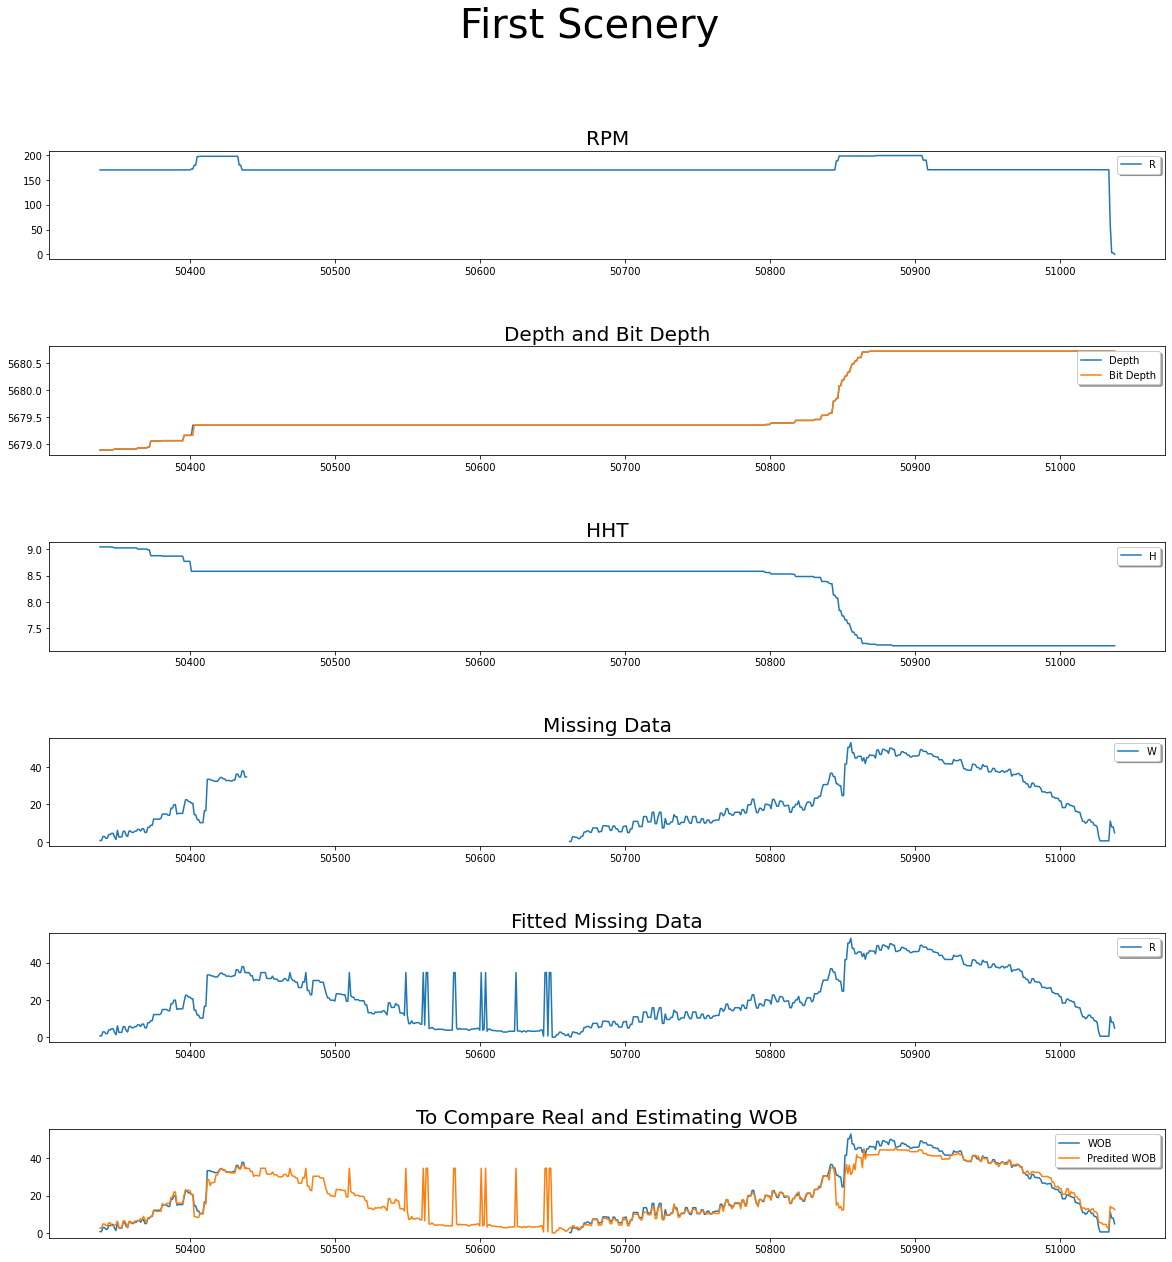

## <span style='color:blue'>First Scenery - MAE: 1.8914</span>

In [31]:
segment = 3
scenery = 'First Scenery'
plot_predictions(df, segment=segment, scenery=scenery)
#print_estimtion(df, segment=segment)
mae, _, _, _, _, _, _ = calc_regression_error(df, segment=segment)
score = f"## <span style='color:blue'>{scenery} - MAE: {mae}</span>"
display(Markdown(score))

## ___Second scenery to be analyzed___

The second scenery was in the same status as the first one, rotation and the drilling bit is touching the well bottom. Nevertheless, the hook height (the third graph) is nearby the probe ground 

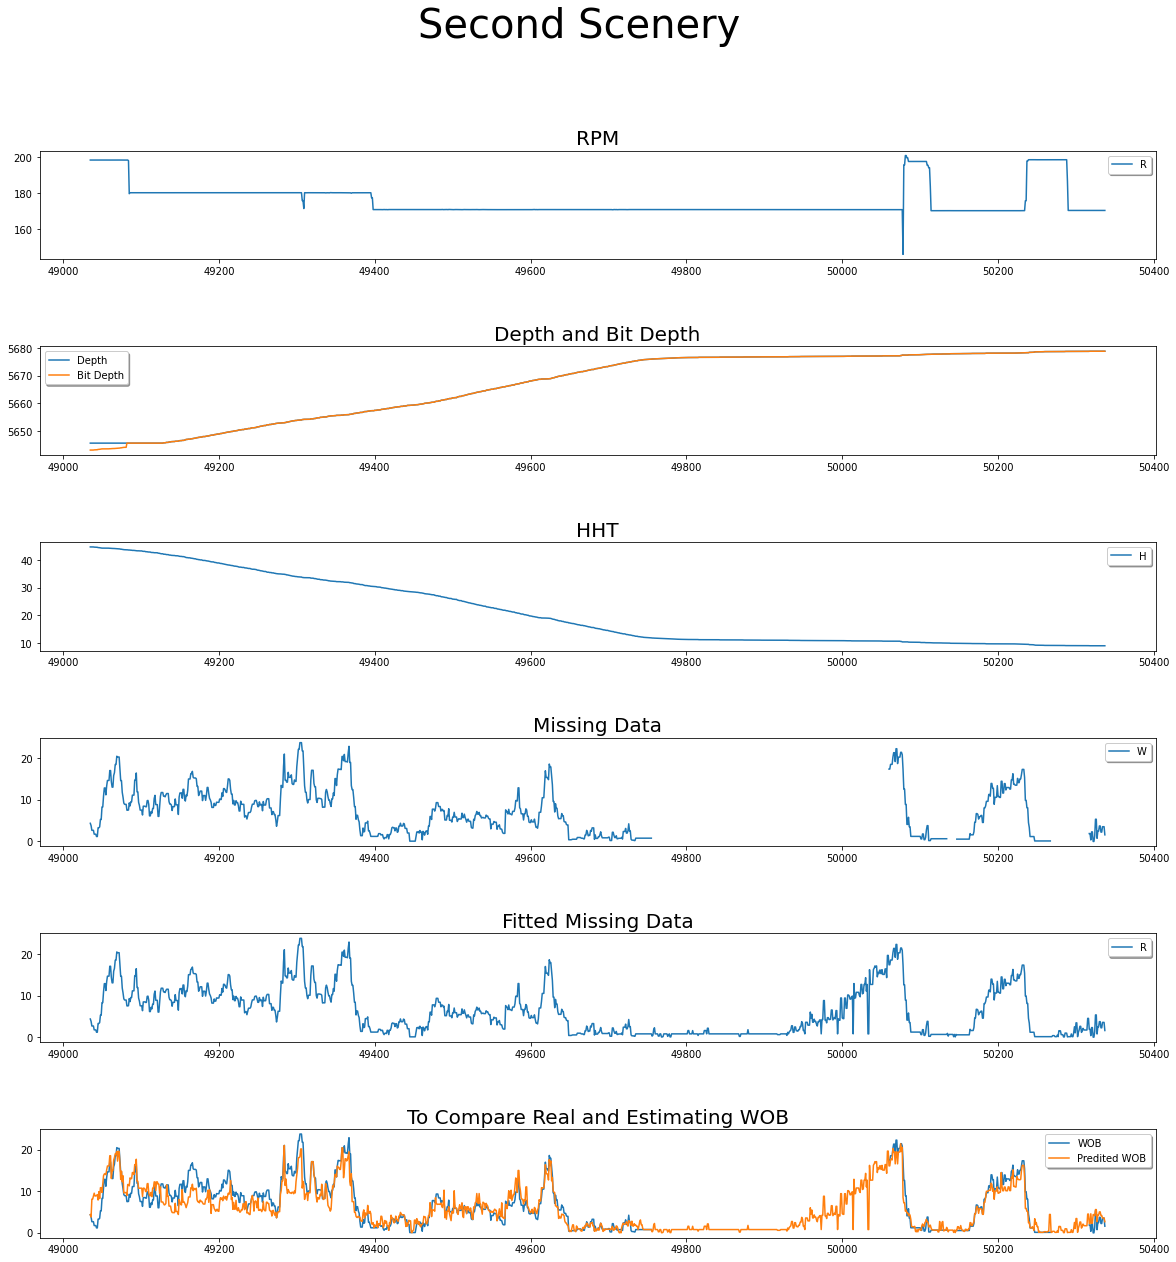

## <span style='color:blue'>Second Scenery - MAE: 1.7005</span>

In [32]:
segment = 4
scenery = 'Second Scenery'
plot_predictions(df, segment=segment, scenery=scenery)
#print_estimtion(df, segment=segment)
mae, _, _, _, _, _, _ = calc_regression_error(df, segment=segment)
score = f"## <span style='color:blue'>{scenery} - MAE: {mae}</span>"
display(Markdown(score))

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Processing time</h2>
</div>

In [33]:
finish = time()
total_time = round((finish - start) / 60, 2)
unit = 'min'
if total_time > 60:
    total_time = total_time / 60
    unit = 'hrs'

now = datetime.now()
finish = datetime.strftime(now, '%d/%m/%Y, %H:%M')
print(f'{finish} | Total time {round(total_time, 2)} {unit}')

18/07/2022, 23:03 | Total time 10.09 min


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Result</h2>
</div>

The model to fit the WOB missing data presents a good accuracy in the current well drilling dataset. The well lithology (The rock formation) has a great influence on the drilling behaviour, where the probe operator make a decision in applying more weight on bit and varying the bit rotation.

It is necessary to train the model including a variety of lithology and different kinds of drilling probes to evolve the generalization of the model.